In [1521]:
import math
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable
from numpy import linalg

## Gradient Descent implementation

Обобщённая реализация градиентного спуска

In [1522]:
def grad_descent(
    grad: Callable[[np.ndarray], np.ndarray], # gradient of f(x)
    x0: np.ndarray,                           # starting point of the descent
    step_fun: Callable[[list], float],        # function which decides the length of the next step
    max_epoch: int = 100,                     # algorithm stops when number of iterations reach max_epoch
    eps: float = 0                            # algorithm stops when ||grad(x)|| < eps
) -> np.ndarray:                              # returns the path gradient descent takes from x0
  points = [x0]

  for i in range(1, max_epoch):
    x_prev = points[-1]
    lr: float = step_fun(points)
    x_new: np.ndarray = x_prev - lr * grad(x_prev)
    points.append(x_new)
    if linalg.norm(grad(x_new), len(x_new)) < eps:
      break

  return np.array(points)

## Constant Learning rate

реализация градиентного спуска с постоянным шагом

In [1523]:
def gd_const_lr(
        grad: Callable,
        x0: np.ndarray,
        lr: float, # constant learning rate
        max_epoch: int = 10,
        eps: float = 0
) -> np.ndarray:
  return grad_descent(grad, x0, lambda _: lr, max_epoch, eps)

Исследуем сходимость на функции f с градиентом grad

In [1524]:
def f(v: np.ndarray) -> float:
  x, y = v
  return 4 * (x + 1) ** 2 + y ** 2 + (x + 1) * y ** 2 + 1


def grad(v: np.ndarray) -> np.ndarray:
  x, y = v
  return np.array([8 * (x + 1) + y ** 2, + 2 * y + 2 * (x + 1) * y])


x0 = np.array([-0.5, 1])

График показывает, как сильно сходится функция f на 10 итерация градиентного спуска
в зависимости от выбранного шага.

На нём видно, что при сильно большом или маленьком шаге результаты будут плохие.

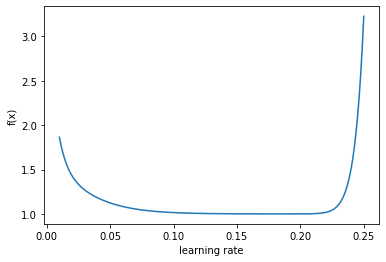

In [1525]:
lrs = np.linspace(0.01, 0.25, 1000)
results = np.vectorize(lambda lr: f(gd_const_lr(grad, x0, lr, max_epoch=10)[-1]))(lrs)

plt.plot(lrs, results)
plt.xlabel('learning rate')
plt.ylabel('f(x)')
plt.show()

На этих 4 графиках наглядно видно как ведёт себя градиентный спуск с разной длиной шага на 20 итерациях.

* маленький - медленно сходится к точке минимума
* неплохой - сходится быстрее
* большой - медленно сходится, перескакивая точку минимума
* слишко большой - рассходится

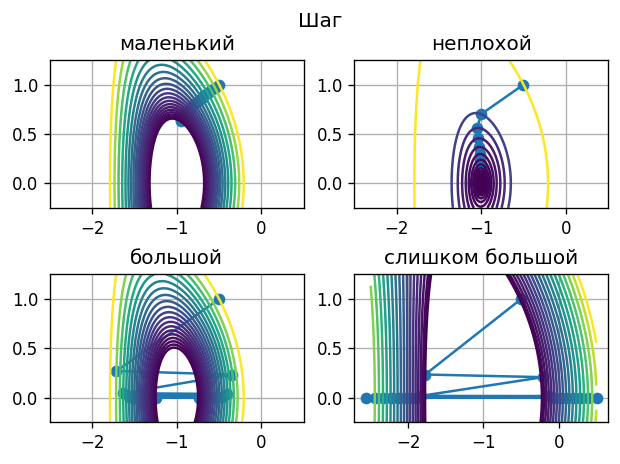

In [1526]:
t = np.linspace(-1.5, 1.5, 1000)
X, Y = np.meshgrid(t - 1, (t + 1) / 2)
fig = plt.figure(dpi=120)
fig.suptitle('Шаг')


def plot_const_lr(n: int, lr: float, title: str):
  points = gd_const_lr(grad, x0, lr, max_epoch=20)
  plt.subplot(n)
  plt.grid(True)
  plt.title(title)
  plt.plot(points[:, 0], points[:, 1], 'o-')
  plt.contour(X, Y, f(np.array([X, Y])), levels=sorted([f(p) for p in points]))


plot_const_lr(221, 0.01, 'маленький')
plot_const_lr(222, 0.1, 'неплохой')
plot_const_lr(223, 0.243, 'большой')
plot_const_lr(224, 0.255, 'слишком большой')
plt.subplots_adjust(hspace=0.45)
plt.show()

## Learning rate scheduling

Реализации градиентного спуска со ступенчатой и экспоненциальной
функциями изменения шага.

In [1527]:
def gd_stepping_lr(
        grad: Callable[[np.ndarray], np.ndarray],
        x0: np.ndarray,
        a0: float, # initial learning rate
        d: float,  # decay parameter
        r: int,    # droprate
        max_epoch: int = 10,
        eps: float = 0
) -> np.ndarray:
  def step(points: list) -> float:
    return a0 * d ** ((1 + len(points)) // r)

  return grad_descent(grad, x0, step, max_epoch, eps)


def gd_exponential_lr(
        grad: Callable[[np.ndarray], np.ndarray],
        x0: np.ndarray,
        a0: float, # initial learning rate
        d: float,  # decay parameter
        max_epoch: int = 10,
        eps: float = 0
) -> np.ndarray:
  def step(points: list) -> float:
    return a0 / math.e ** (d * len(points))

  return grad_descent(grad, x0, step, max_epoch, eps)

На этой гистограмме показано, что с переменным шагом скорость сходимости выше.

Начальный размер шага у всех спуков одинаковый - 0.21, однако в переменном случае он постепенно снижается.

Number of epoches before ||∇f(x)|| < eps:
With constant learning rate - 24
With stepping scheduling    - 17
With exponential scheduling - 18


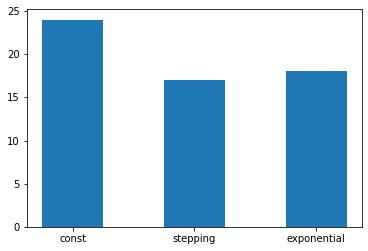

In [1528]:
max_epoch: int = 40
eps = 0.001
points_const = gd_const_lr(grad, x0, 0.21, max_epoch=max_epoch, eps=eps)
points_stepping = gd_stepping_lr(grad, x0, 0.21, 0.95, 5, max_epoch=max_epoch, eps=eps)
points_exponential = gd_exponential_lr(grad, x0, 0.21, 0.02, max_epoch=max_epoch, eps=eps)

print('Number of epoches before ||∇f(x)|| < eps:')
print('With constant learning rate -', len(points_const))
print('With stepping scheduling    -', len(points_stepping))
print('With exponential scheduling -', len(points_exponential))
plt.bar(['const', 'stepping', 'exponential'],
        [len(points_const), len(points_stepping), len(points_exponential)],
        width = 0.5)
plt.show()

## One-dimensional search

Реализация метода золотого сечения

(a, b) - интервал поиска минимума

In [1529]:
golden_ratio = (math.sqrt(5) - 1) / 2
golden_ratio2 = (3 - math.sqrt(5)) / 2

def golden_section(
        f: Callable[[float], float],
        a: float,
        b: float,
        eps: float = 0.001
) -> float:
  h = b - a
  c = a + golden_ratio2 * h
  d = a + golden_ratio * h
  fc = f(c)
  fd = f(d)

  while h > eps:
    h *= golden_ratio
    if fc < fd:
      # go to (a, d)
      b = d
      d = c
      fd = fc
      c = a + golden_ratio2 * h
      fc = f(c)
    else:
      # go to (c, b)
      a = c
      c = d
      fc = fd
      d = a + golden_ratio * h
      fd = f(d)

  return (a + b) / 2

Реализация метода золотого сечения с использованием условий Вольфе в качестве критерия остановки

Константы $c_1$ и $c_2$ передаются как аргументы, также потребовалось использование некоторой функции
$g(\alpha)$, представляющей собой правую часть во втором неравенстве Вольфе.

In [1530]:
def golden_section_wolfe(
        f: Callable[[float], float],
        g: Callable[[float], float],
        gr: np.ndarray,
        a: float,
        b: float,
        c1: float = 0.001,
        c2: float = 0.99,
) -> float:
  not_wolfe = True

  h = b - a
  c = a + golden_ratio2 * h
  d = a + golden_ratio * h
  fc = f(c)
  fd = f(d)
  fx_k = f(0)
  gr_sqr_neg = - gr.dot(gr)
  c1_coef = c1 * gr_sqr_neg
  c2_coef = c2 * gr_sqr_neg
  it = 0

  while not_wolfe:
    h *= golden_ratio
    if fc < fd:
      # go to (a, d)
      b = d
      d = c
      fd = fc
      c = a + golden_ratio2 * h
      fc = f(c)
    else:
      # go to (c, b)
      a = c
      c = d
      fc = fd
      d = a + golden_ratio * h
      fd = f(d)
    alpha = (a + b) / 2
    it += 1
    not_wolfe = it < 10 and (f(alpha) > fx_k + alpha * c1_coef or g(alpha) < c2_coef)
  return alpha

Реализации градиентного спуска с использованием одномерного поиска для нахождения шага на каждой итерации.

In [1531]:
def gd_one_dim(
        f: Callable[[np.ndarray], float],
        grad: Callable[[np.ndarray], np.ndarray],
        x0: np.ndarray,
        max_epoch: int = 10,
        eps: float = 0.001
) -> np.ndarray:

  def step(points: list) -> float:
    x = points[-1]
    gr = grad(x)
    return golden_section(lambda lr: f(x - lr * gr), 0, 2, 1e-3)

  return grad_descent(grad, x0, step, max_epoch, eps)

Функция $g(\alpha)$ здесь передаётся вторым аргументом и представляет собой левую часть
неравенства второго условия Вольфе

In [1532]:
def gd_one_dim_wolfe(
        f: Callable[[np.ndarray], float],
        grad: Callable[[np.ndarray], np.ndarray],
        x0: np.ndarray,
        max_epoch: int = 10,
        eps: float = 0.001
) -> np.ndarray:

  def step(points: list) -> float:
    x = points[-1]
    gr = grad(x)
    return golden_section_wolfe(lambda lr: f(x - lr * gr), lambda lr: -gr.dot(grad(x - lr * gr)), gr, 0, 2, 0.5, 0.75)
  # 0.2, 0.8 -> 1720, 322
  # 0.3 0.75 -> 1646, 307
  # 0.4 0.75 -> 1555, 287
  # 0.5 0.75 -> 1465, 258

  return grad_descent(grad, x0, step, max_epoch, eps)

Исследуем сходимость на функции f2 с градиентом grad2.

Каждое вычисление grad2 требует 4 вычислений f2.

сf и cg нужны для подсчёта числа вызовов этих фунцкий.

In [1533]:
cf: int
cg: int

def f2(v: np.ndarray) -> float:
  x, y = v
  global cf
  cf += 1
  return np.sin(0.5 * x**2 - 0.25 * y**2 + 3)*np.cos(2*x+1-np.exp(y))
  # return np.sin(2 * x**3 - 0.3 * y**4 + 5)
  # return np.sin(2 * x**3 - 0.3 * y**4 + 5)*np.cos(2*x+1-np.exp(y))

def grad2(v: np.ndarray) -> np.ndarray:
  x, y = v
  global cg
  cg += 1
  h = 1e-5
  return np.array([
    (f2(np.array([x + h, y])) - f2(np.array([x - h, y])))/(2*h),
    (f2(np.array([x, y + h])) - f2(np.array([x, y - h])))/(2*h)
  ])


x0 = np.array([-0.1, -0.4])

Сравним спуск со ступенчатым изменением шага и с одномерным поиском.

Как видно на гистограмме, число вызовов градиента grad2 у градиентного спуска с одномерным поиском заметно ниже.
Но число вызовов функции f2 примерно равно, т.к. ступенчатый спуск не требует вычисления функции для расчёта длины шага.
Однако с уменьшением eps разница числа вызовов f и grad растёт.

Min values for lr: -0.041983264453810835, od: -0.04198326459031486, wolfe: -0.04198326451966281


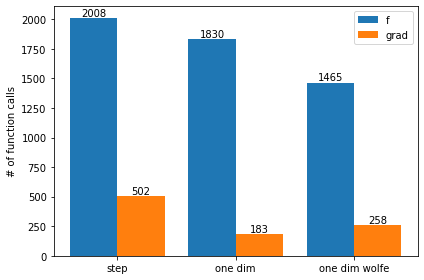

In [1534]:
max_epoch=100000
eps=1e-5

labels = ['step', 'one dim', 'one dim wolfe']
f_counts = [0, 0, 0]
g_counts = [0, 0, 0]

cf, cg = 0, 0
lr_path = gd_stepping_lr(grad2, x0, 0.25, 0.9, 50, max_epoch=max_epoch, eps=eps)
f_counts[0], g_counts[0] = cf, cg

cf, cg = 0, 0
od_path = gd_one_dim(f2, grad2, x0, max_epoch=max_epoch, eps=eps)
f_counts[1], g_counts[1] = cf, cg

cf, cg = 0, 0
wolfe_path = gd_one_dim_wolfe(f2, grad2, x0, max_epoch=max_epoch, eps=eps)
f_counts[2], g_counts[2] = cf, cg


x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, f_counts, width, label='f')
rects2 = ax.bar(x + width/2, g_counts, width, label='grad')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of function calls')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),
                    textcoords="offset points",
                    ha='center', va='bottom')
lr_f = f2(lr_path[-1])
od_f = f2(od_path[-1])
wolfe_f = f2(wolfe_path[-1])
print(f"Min values for lr: {lr_f}, od: {od_f}, wolfe: {wolfe_f}")
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

## Gradient descent trajectory for quadratic functions

Попытаемся посмотреть, как поведёт себя градиентный спуск на различных квадратичных
задачах. Здесь число обусловленности больше $1$, о чём говорит растяжение линий уровня
в эллипсы, не окружности.

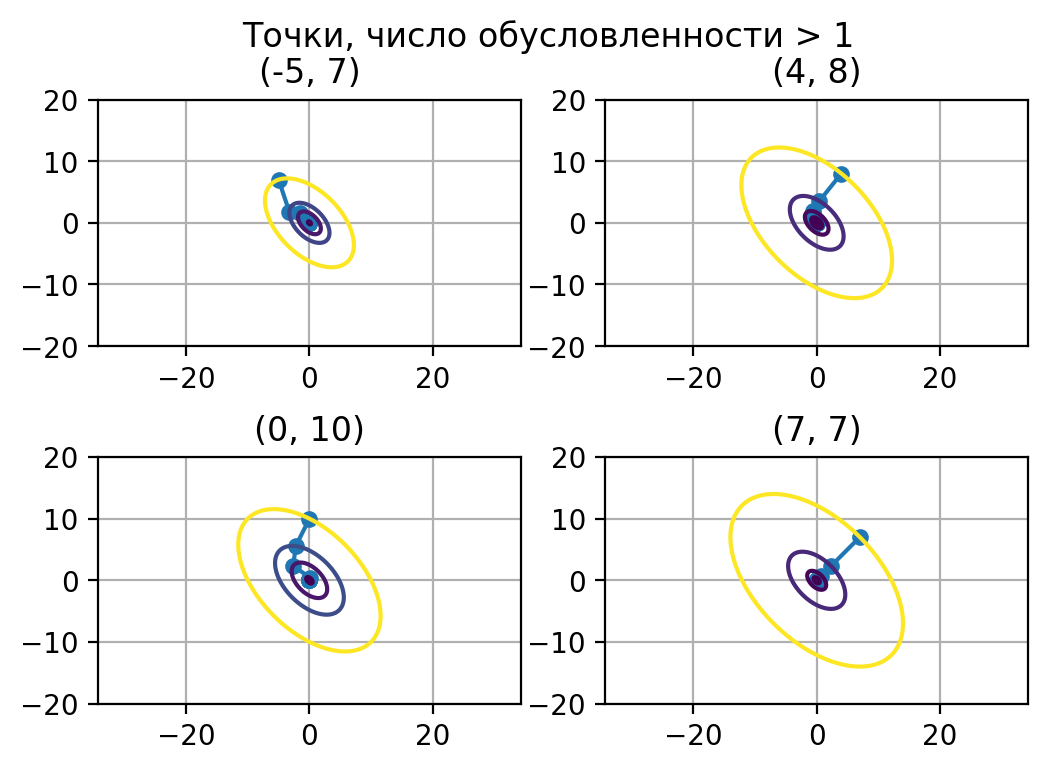

In [1535]:
def f_q1(v: np.ndarray) -> float:
  x, y = v
  return 4 * x**2 + 4 * y**2 + 4 * x * y


def grad_q1(v: np.ndarray) -> np.ndarray:
  x, y = v
  return np.array([8 * x + 4 * y, 8 * y + 4 * x])

t = np.linspace(-20, 20, 1000)
X, Y = np.meshgrid(t, t)
fig = plt.figure(dpi=200)
fig.suptitle('Точки, число обусловленности > 1')


def plot_quadratic(f, grad, x0, n: int, title: str):
  points = gd_one_dim_wolfe(f, grad, x0, max_epoch=20)
  plt.subplot(n)
  plt.grid(True)
  plt.title(title)
  plt.axis('equal')
  plt.plot(points[:, 0], points[:, 1], 'o-', ms=5)
  plt.contour(X, Y, f(np.array([X, Y])), levels=sorted([f(p) for p in points]))

x0s = np.array([[-5, 7], [4, 8], [0, 10], [7, 7]])
i = 1
for pt in x0s:
  plot_quadratic(f_q1, grad_q1, pt, 220 + i, f'({pt[0]}, {pt[1]})')
  i += 1
plt.subplots_adjust(hspace=0.45)
plt.show()

Здесь число обусловленности равно единице, минимум смещён от начала координат.

При таком числе обусловленности градиентный спуск очень быстро находит минимум
(если использовать $\varepsilon$ в качестве критерия остановки, доходит вообще
за один шаг)

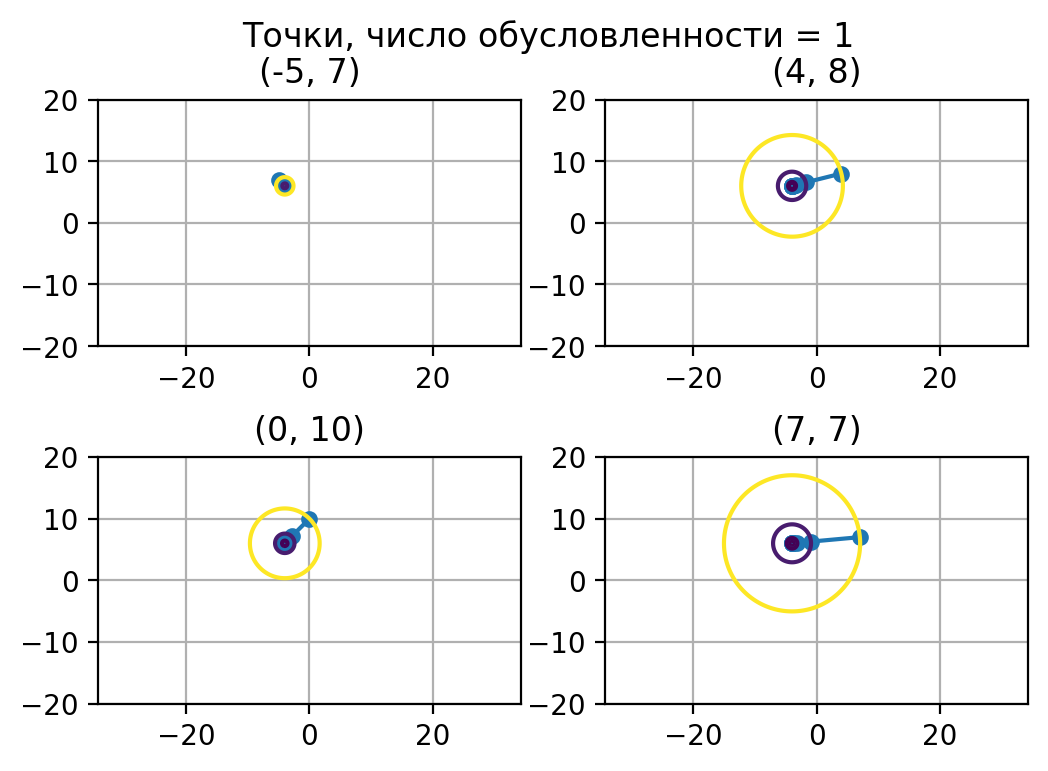

In [1536]:
def f_q2(v: np.ndarray) -> float:
  x, y = v
  return 4 * x**2 + 4 * y**2 + 32 * x - 48 * y


def grad_q2(v: np.ndarray) -> np.ndarray:
  x, y = v
  return np.array([8 * x + 32, 8 * y - 48])

fig = plt.figure(dpi=200)
fig.suptitle('Точки, число обусловленности = 1')

i = 1
for pt in x0s:
  plot_quadratic(f_q2, grad_q2, pt, 220 + i, f'({pt[0]}, {pt[1]})')
  i += 1
plt.subplots_adjust(hspace=0.45)
plt.show()

Здесь число обусловленности много больше 1, и метод расходится

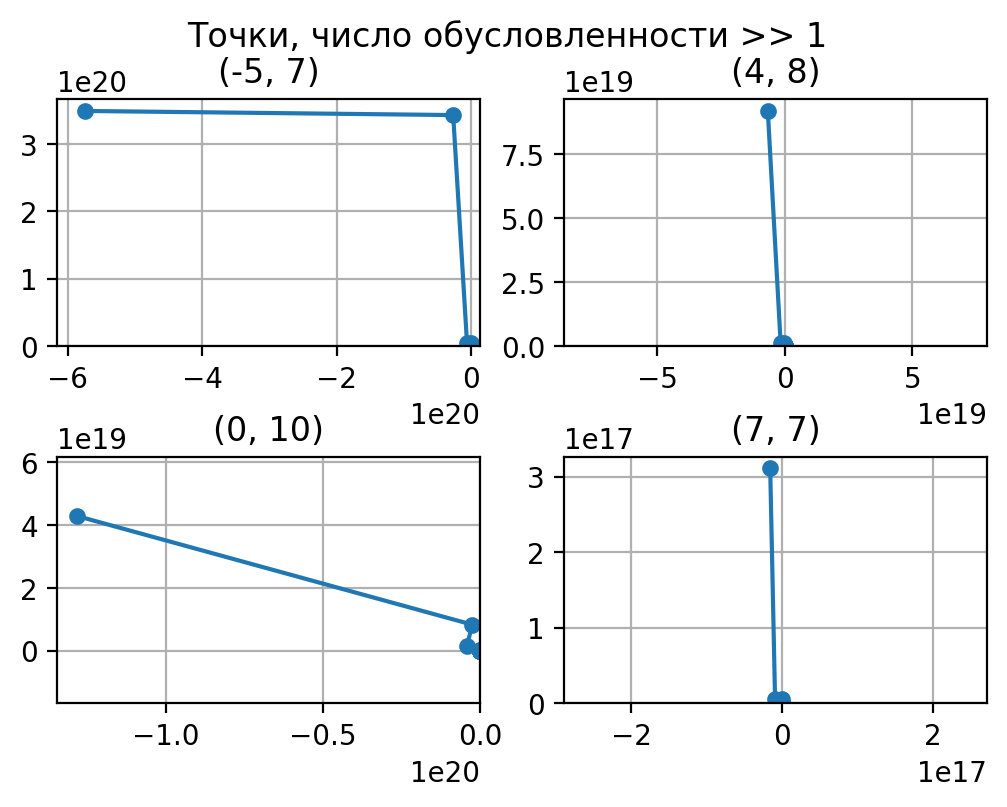

In [1537]:
def f_q3(v: np.ndarray) -> float:
  x, y = v
  return 9 * x**2 + y**2 + 30 * x * y


def grad_q3(v: np.ndarray) -> np.ndarray:
  x, y = v
  return np.array([18 * x + 30 * y, 2 * y + 30 * x])

fig = plt.figure(dpi=200)
fig.suptitle('Точки, число обусловленности >> 1')

i = 1
for pt in x0s:
  plot_quadratic(f_q3, grad_q3, pt, 220 + i, f'({pt[0]}, {pt[1]})')
  i += 1
plt.subplots_adjust(hspace=0.45)
plt.show()

## Number of iterations dependency on k, n

Сгенерируем задачу таким образом: пусть матрица $A$ будет состоять только из
чисел на главной диагонали (остальные - нули). Тогда представить её можно
только этой диагональю, так что от матрицы храним только вектор чисел
на главной диагонали. Это и есть собственные числа этой матрицы.

Учитывая использованную последовательность, максимальное собственное число матрицы
здесь равно $k$, минимальное - $1$. Соответственно, их отношение и есть
число обусловленности квадратичной задачи.

Генерируем функцию как поэлементное возведение в квадрат координат входящего вектора,
перемноженное скалярно с вектором главной диагонали матрицы $A$. Градиент -- поэлементное
умножение чисел из главной диагонали матрицы $A$ и удвоенных координат входящего вектора.

Начальную точку берём произвольную из гиперкуба $[-10, 10]^n$

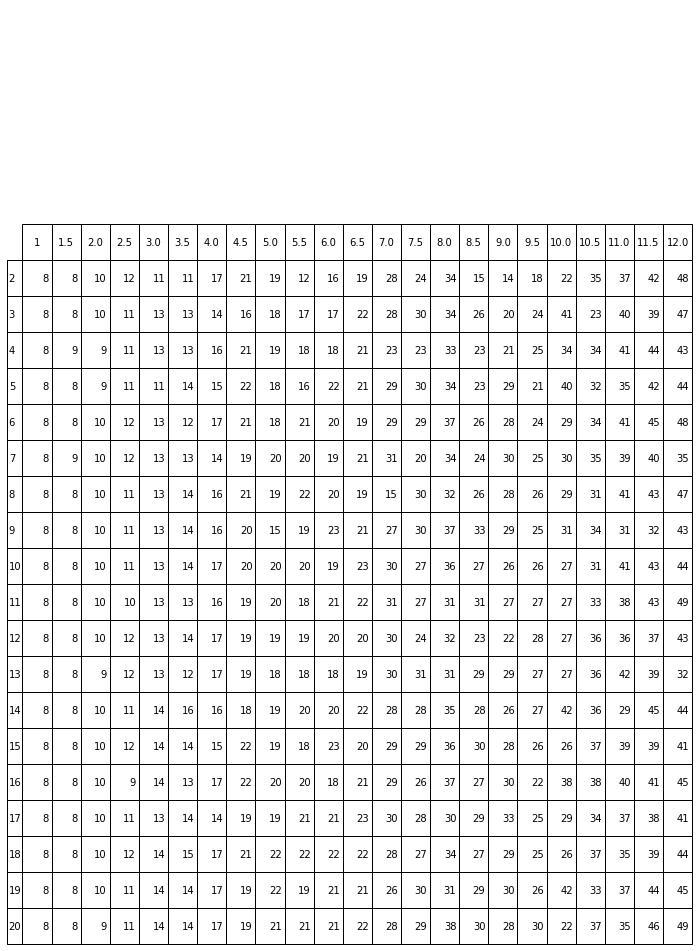

In [1538]:
def generate_task(
  n: int,
  k: float
) -> (Callable[[np.array], float], Callable[[np.array], np.array], np.array):
  A = np.array([1 + (k - 1) * i / (n - 1) for i in range(n)])
  f = lambda x: A.dot(x ** 2)
  grad = lambda x: 2 * A * x
  x0 = np.random.sample(n) * 20 - 10
  return f, grad, x0


def statT(n_max: int, k_max: float, k_step: float):
  ns = [i for i in range(2, n_max + 1)]
  ks = []
  kit = 1
  while kit <= k_max:
    ks.append(kit)
    kit += k_step
  stat = [[-1 for j in range(len(ks))] for i in range(len(ns))]
  for nit, n in enumerate(ns):
    for kit, k in enumerate(ks):
      f, grad, x0 = generate_task(n, k)
      stat[nit][kit] = len(gd_one_dim_wolfe(f, grad, x0, 100, 0.001))
  return ns, ks, stat

ns, ks, stat = statT(20, 12, 0.5)
fig, ax = plt.subplots()
ax.set_axis_off()
tbl = ax.table(stat, rowLabels=ns, colLabels=ks)
tbl.scale(2, 3)
plt.show()

Как мы видим, от числа переменных зависимости нет, от числа обусловленности же
зависимость пропорциональная: чем больше $k$, тем больше и число итераций